In [1]:
import pandas as pd
import numpy as np
import panel as pn
pn.extension('tabulator')
import hvplot.pandas

data_path = 'https://raw.githubusercontent.com/owid/co2-data/master/owid-co2-data.csv'

In [2]:
df = pd.read_csv(data_path)
# keep all the rows after 1920
df = df[df['year'] >= 1920]
print(df.shape)
df.head()

(27743, 79)


,country,year,iso_code,population,gdp,cement_co2,cement_co2_per_capita,co2,co2_growth_abs,co2_growth_prct,...,share_global_other_co2,share_of_temperature_change_from_ghg,temperature_change_from_ch4,temperature_change_from_co2,temperature_change_from_ghg,temperature_change_from_n2o,total_ghg,total_ghg_excluding_lucf,trade_co2,trade_co2_share
70,Afghanistan,1920,AFG,10188845.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.138,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
71,Afghanistan,1921,AFG,10162753.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.138,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
72,Afghanistan,1922,AFG,9893152.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.137,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
73,Afghanistan,1923,AFG,9374030.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.136,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
74,Afghanistan,1924,AFG,8882148.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.135,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [3]:
df = df.fillna(0)
# creation of a gdp per capita column
df['gdp_per_capita'] = np.where(df['population']!= 0, df['gdp']/ df['population'], 0)

idf = df.interactive()

In [4]:
#initiate year slider
year_slider = pn.widgets.IntSlider(name='Year slider', start=1920, end=2023, step=1, value=1920)
year_slider

IntSlider(end=2023, name='Year slider', start=1920, value=1920)

# CO2 OVER TIME BY CONTINENT

In [5]:
#buttons for CO2 measures
yaxis_co2 = pn.widgets.RadioButtonGroup(
    name='Y axis', 
    options=['co2', 'co2_per_capita',],
    button_type='success'
)
continents = ['World', 'Asia', 'Oceania', 'Europe', 'Africa', 'North America', 'South America', 'Antarctica']

co2_pipeline = (
    idf[
        (idf.year <= year_slider) &
        (idf.country.isin(continents))
    ]
    .groupby(['country', 'year'])[yaxis_co2].mean()
    .to_frame()
    .reset_index()
    .sort_values(by='year')  
    .reset_index(drop=True)
)

In [6]:
co2_pipeline

In [7]:
co2_plot = co2_pipeline.hvplot(x = 'year', by='country', y=yaxis_co2,line_width=2, title="CO2 emission by continent")
co2_plot

In [8]:
co2_table = co2_pipeline.pipe(pn.widgets.Tabulator, pagination='remote', page_size = 10, sizing_mode='stretch_width') 
co2_table

In [9]:
co2_vs_gdp_scatterplot_pipeline = (
    idf[
        (idf.year == year_slider) &
        (~ (idf.country.isin(continents)))
    ]
    .groupby(['country', 'year', 'gdp_per_capita'])['co2'].mean()
    .to_frame()
    .reset_index()
    .sort_values(by='year')  
    .reset_index(drop=True)
)

In [10]:
co2_vs_gdp_scatterplot = co2_vs_gdp_scatterplot_pipeline.hvplot(x='gdp_per_capita', 
                                                                y='co2', 
                                                                by='country', 
                                                                size=80, kind="scatter", 
                                                                alpha=0.7,
                                                                legend=False, 
                                                                height=500, 
                                                                width=500)
co2_vs_gdp_scatterplot

# USA seperation

In [12]:
# filter and create a new df with rows that cointain US
df_usa = df.loc[df['country']=='United States']

# keep the specified columns
df_usa = df_usa.iloc[:,[0,1,3,4,7]]

print(df_usa.shape)

(102, 5)


In [13]:
df_usa.tail()

,country,year,population,gdp,co2
48154,United States,2017,329791232.0,1.759628e+13,5210.958
48155,United States,2018,332140032.0,1.814065e+13,5376.657
48156,United States,2019,334319680.0,0.000000e+00,5259.144
48157,United States,2020,335942016.0,0.000000e+00,4715.691
48158,United States,2021,336997632.0,0.000000e+00,5007.336


In [14]:
def format_gdp(number):
    """
    This function converts a GDP value to a float32 value with an appropriate scale
    ('trillions', 'billions', or 'millions'), depending on its size
    
    Returns:
    numpy.float32: The formatted GDP value in float32.
    """
    if number >= 1e12:
        return np.float32(number / 1e12)
    elif number >= 1e9:
        return np.float32(number / 1e9)
    elif number >= 1e6:
        return np.float32(number / 1e6)
    else:
        return np.float32(number)



df_usa['gdp_trillions'] = df_usa['gdp'].apply(format_gdp)

In [15]:
#start year from 1920 as that is the first year we get info on oil prod
df_usa = df_usa.loc[df['year']>=1920]

df_usa['population_in_millions'] = df_usa['population'] / 1000000

# keep the specific columns
df_usa = df_usa.iloc[:,[0,1,4,5,6]]

# Replace 0 values for the following years
df_usa.loc[df_usa['year'] == 2019, 'gdp_trillions'] = 21.38
df_usa.loc[df_usa['year'] == 2020, 'gdp_trillions'] = 21.06
df_usa.loc[df_usa['year'] == 2021, 'gdp_trillions'] = 23.32

#df_usa.tail()

C:\Users\hile9\AppData\Local\Temp\ipykernel_7920\1725304779.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '21.38' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df_usa.loc[df_usa['year'] == 2019, 'gdp_trillions'] = 21.38


In [16]:
df_usa.dtypes

country                    object
year                        int64
co2                       float64
gdp_trillions             float64
population_in_millions    float64
dtype: object

# OIL

In [17]:
oil=pd.read_excel('oil.xls',sheet_name = 1, skiprows = 2)
oil.head()

,Date,U.S. Field Production of Crude Oil (Thousand Barrels)
0,1920-01-15,34008
1,1920-02-15,33193
2,1920-03-15,36171
3,1920-04-15,34945
4,1920-05-15,36622


In [18]:
# change datatype for the date column
oil['Date'] = pd.to_datetime(oil['Date'])

# extract the year
oil['Year'] = oil['Date'].dt.year

# sum all months to get a years total
oil_group = oil.groupby('Year')['U.S. Field Production of Crude Oil (Thousand Barrels)'].sum()

oil_group = oil_group.reset_index()

oil = oil_group
#oil.head()

# oil production dashboard

In [19]:
df_usa.rename(columns={'year': 'Year'}, inplace=True)

# merge the dataframes on year
merged_df = pd.merge(df_usa, oil, on='Year', how='outer')

#merged_df=merged_df.fillna(0)
## add missing values manually
merged_df.iloc[-2, 0] = 'United States'  
merged_df.iloc[-2, 2] = 5072.431         
merged_df.iloc[-2, 3] = 25.46            
merged_df.iloc[-2, 4] = 333.287557
# drop last row
merged_df = merged_df[:-1]

merged_df.tail()

,country,Year,co2,gdp_trillions,population_in_millions,U.S. Field Production of Crude Oil (Thousand Barrels)
98,United States,2018,5376.657,18.140646,332.140032,3997179
99,United States,2019,5259.144,21.380000,334.319680,4493544
100,United States,2020,4715.691,21.060000,335.942016,4142505
101,United States,2021,5007.336,23.320000,336.997632,4112720
102,United States,2022,5072.431,25.460000,333.287557,4347377


In [20]:
# Graph comparing CO2 emissions with Oil Production
# Convert oil production from total annual to daily (kbd)
merged_df['U.S. Field Production of Crude Oil (kbd)'] = merged_df['U.S. Field Production of Crude Oil (Thousand Barrels)'] / 365

# Updating the plot
co2_oil_plot = merged_df.hvplot(x='Year', y='co2', label='CO2 Emissions') * \
               merged_df.hvplot(x='Year', y='U.S. Field Production of Crude Oil (kbd)', label='Oil Production (kbd)')

co2_oil_plot.opts(title="CO2 Emissions vs Oil Production (kbd)")

:Overlay
   .Curve.CO2_Emissions                                         :Curve   [Year]   (co2)
   .Curve.Oil_Production_left_parenthesis_kbd_right_parenthesis :Curve   [Year]   (U.S. Field Production of Crude Oil (kbd))

In [21]:
# Calculate the correlation between CO2 emissions and the Oil Production
correlation_co2_oil = merged_df['co2'].corr(merged_df['U.S. Field Production of Crude Oil (kbd)'])

correlation_co2_oil

0.6395064073572256

<BarContainer object of 21 artists>

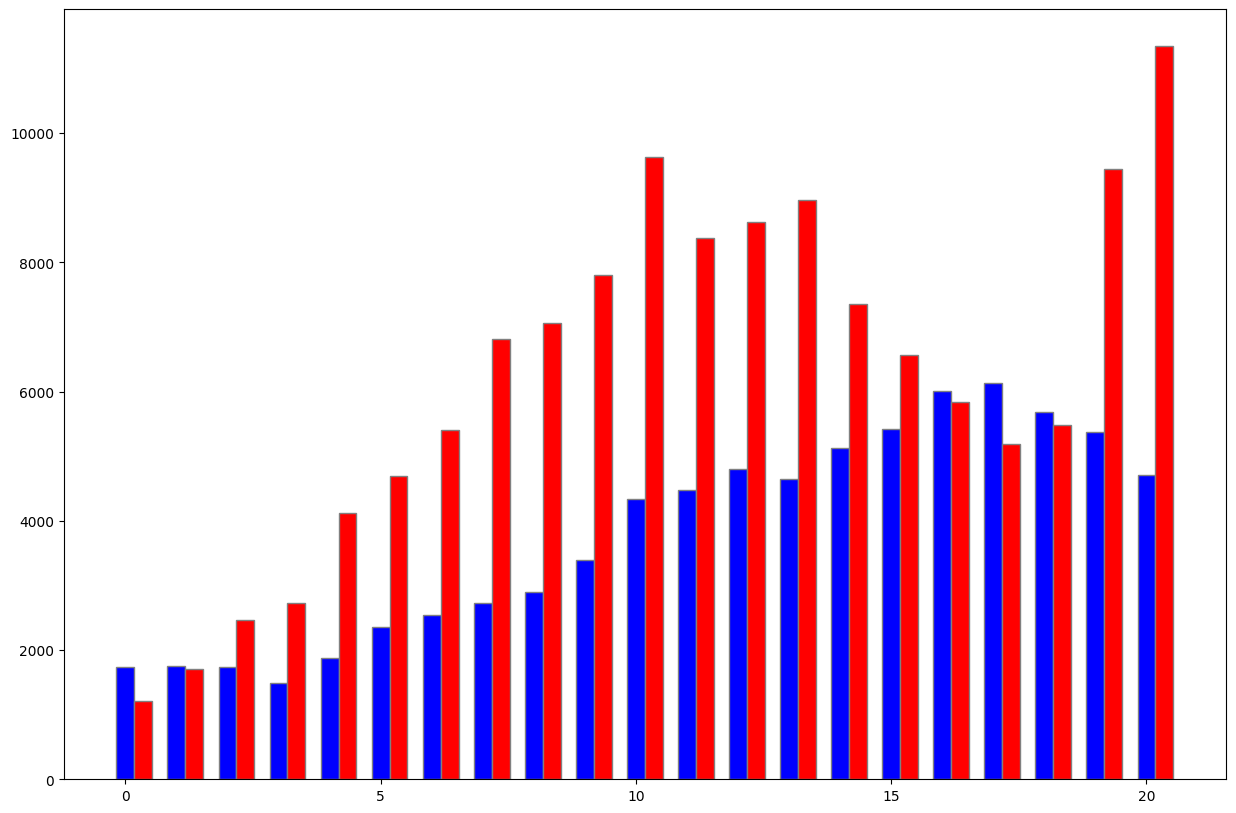

In [22]:
import matplotlib.pyplot as plt

filtered_df = merged_df[merged_df['Year'] >= 1920]

# Generate the list of years from 1920 to the max year with step 5
years = range(1920, filtered_df['Year'].max() + 1, 5)

co2_emissions = [filtered_df[filtered_df['Year'] == year]['co2'].sum() for year in years]
oil_production = [filtered_df[filtered_df['Year'] == year]['U.S. Field Production of Crude Oil (kbd)'].sum() for year in years]

bar_width = 0.35

# The x position of bars
r1 = np.arange(len(co2_emissions))
r2 = [x + bar_width for x in r1]

# Create figure and the bar charts
fig, ax = plt.subplots(figsize=(15, 10))  # Increase the figure size as needed
ax.bar(r1, co2_emissions, color='b', width=bar_width, edgecolor='grey', label='CO2 Emissions')
ax.bar(r2, oil_production, color='r', width=bar_width, edgecolor='grey', label='Oil Production (kbd)')

In [23]:
import io
import matplotlib.pyplot as plt
import panel as pn

# Generate the Matplotlib plot
fig, ax = plt.subplots(figsize=(15, 10))
ax.bar(r1, co2_emissions, color='b', width=bar_width, edgecolor='grey', label='CO2 Emissions')
ax.bar(r2, oil_production, color='r', width=bar_width, edgecolor='grey', label='Oil Production (kbd)')

# Add labels title and a legend
ax.set_xlabel('Year', fontweight='bold')
ax.set_xticks(r1)
ax.set_xticklabels(years, rotation=90)  # Rotate x-axis labels if needed
ax.set_ylabel('Values')
ax.set_title('CO2 Emissions vs Oil Production (kbd) is USA')
ax.legend()
# Save the figure to a BytesIO object
buf = io.BytesIO()
plt.savefig(buf, format='png')
plt.close(fig)
buf.seek(0)

# Use the BytesIO to create a pane
matplotlib_pane = pn.pane.PNG(buf, width=600, height=400, sizing_mode='scale_both')

# template
template = pn.template.FastListTemplate(
    title='CO2 in the world', 
    sidebar=[pn.pane.Markdown("# CO2 Emissions"),
             pn.pane.PNG('tree.png', sizing_mode='scale_both'),
             pn.pane.Markdown("## Settings"),   
             year_slider],
    main=[pn.Row(pn.Column(yaxis_co2, 
                           co2_plot.panel(width=700), margin=(0,25)), 
                 co2_table.panel(width=500)),
          pn.Row(pn.Column(co2_vs_gdp_scatterplot.panel(width=600), margin=(0,25)))],
    accent_base_color="#008000",  # Green color
    header_background="#000000",  # Black color
)

# add the plot to the right
template.main[1] = pn.Row(
    template.main[1][0],  # Keep the existing left column
    pn.Column(matplotlib_pane, margin=(0,25))
)

template.servable()
template.show()

Launching server at http://localhost:64338


In [1]:
import numpy
import matplotlib
import pandas
import panel
import hvplot.pandas  # hvplot extends pandas, so we import it this way

# Getting versions of the requested libraries
print("numpy version:", numpy.__version__)
print("matplotlib version:", matplotlib.__version__)
print("pandas version:", pandas.__version__)
print("panel version:", panel.__version__)
print("hvplot version:", hvplot.__version__)

numpy version: 1.26.0
matplotlib version: 3.8.0
pandas version: 2.1.2
panel version: 1.3.2
hvplot version: 0.9.0
